In [ ]:
import copy
import json
import time
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Qiskit imports
from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization import QuadraticProgram

from docplex.mp.model import Model


In [7]:
with open("etp_problems.json", "r") as file:
    dataset = json.load(file)

dataset = [instance for instance in dataset if instance["instance_id"] != 9]  # Omitting problem 9 due to its intractability for QAOA

# List to store all instance IDs
instance_ids = [instance["instance_id"] for instance in dataset]

# List to store the number of timeslots for each instance
timeslots = [instance["timeslots"] for instance in dataset]

# List of exams for each instance
exams_list = [instance["exams"] for instance in dataset]

# Number of exams for each instance
num_exams_per_instance = [len(instance["exams"]) for instance in dataset]

# List of conflicts for each instance
conflicts_list = [instance["conflicts"] for instance in dataset]

# Step 3: Print the stored variables
print("Instance IDs:", instance_ids)
print("Timeslots:", timeslots)
print("Number of Exams:", num_exams_per_instance)
print("Exams List:")
for i, exams in enumerate(exams_list):
    print(f"Instance {instance_ids[i]} Exams:", exams)

print("\nConflicts List:")
for i, conflicts in enumerate(conflicts_list):
    print(f"Instance {instance_ids[i]} Conflicts:", conflicts)

print("\nExams per problem:")

# Step 3: Print the number of exams for each instance
for i, num_exams in enumerate(num_exams_per_instance):
    print(f"Instance {dataset[i]['instance_id']}: {num_exams} exams")


Instance IDs: [1, 2, 3, 4, 5, 6, 7, 8]
Timeslots: [2, 2, 2, 3, 2, 3, 3, 4]
Number of Exams: [2, 3, 4, 3, 5, 4, 5, 4]
Exams List:
Instance 1 Exams: [{'id': 1, 'name': 'Mathematics 101'}, {'id': 2, 'name': 'English 101'}]
Instance 2 Exams: [{'id': 1, 'name': 'Mathematics 101'}, {'id': 2, 'name': 'English Literature'}, {'id': 3, 'name': 'History'}]
Instance 3 Exams: [{'id': 1, 'name': 'Pure Mathematics'}, {'id': 2, 'name': 'Mechanics'}, {'id': 3, 'name': 'English Language'}, {'id': 4, 'name': 'English Literature'}]
Instance 4 Exams: [{'id': 1, 'name': 'A Level Chemistry'}, {'id': 2, 'name': 'A Level Physics'}, {'id': 3, 'name': 'A Level Biology'}]
Instance 5 Exams: [{'id': 1, 'name': 'Mathematics 101'}, {'id': 2, 'name': 'English 101'}, {'id': 3, 'name': 'Computer Science'}, {'id': 4, 'name': 'Drama'}, {'id': 5, 'name': 'Art'}]
Instance 6 Exams: [{'id': 1, 'name': 'Artificial Intelligence Applications'}, {'id': 2, 'name': 'Data Structures and Algorithms'}, {'id': 3, 'name': 'High Performa

In [8]:
# Encode conflicts for each instance
conflicts_encoded = []

for instance in dataset:
    conflicts = [(conflict["exam1_id"], conflict["exam2_id"]) for conflict in instance["conflicts"]]
    conflicts_encoded.append((instance["instance_id"], conflicts))

# Print encoded conflicts
for instance_id, conflicts in conflicts_encoded:
    print(f"Instance {instance_id} Conflicts: {conflicts}")

Instance 1 Conflicts: [(1, 2)]
Instance 2 Conflicts: [(1, 2), (1, 3)]
Instance 3 Conflicts: [(1, 2), (3, 4)]
Instance 4 Conflicts: [(1, 2), (1, 3), (2, 3)]
Instance 5 Conflicts: [(1, 2), (1, 3), (4, 5)]
Instance 6 Conflicts: [(1, 2), (2, 3), (3, 4), (1, 4), (2, 4)]
Instance 7 Conflicts: [(1, 2), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5)]
Instance 8 Conflicts: [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


In [9]:
def draw_graph(n, e):
    G= nx.Graph()
    G.add_nodes_from([i for i in range(1, n+1)])
    G.add_edges_from(e)
    plt.figure()  # Create a new figure for each graph
    nx.draw(G, with_labels=True)
    plt.title(f"Graph for Problem Instance {problem + 1}")  # Title for each plot
    return G

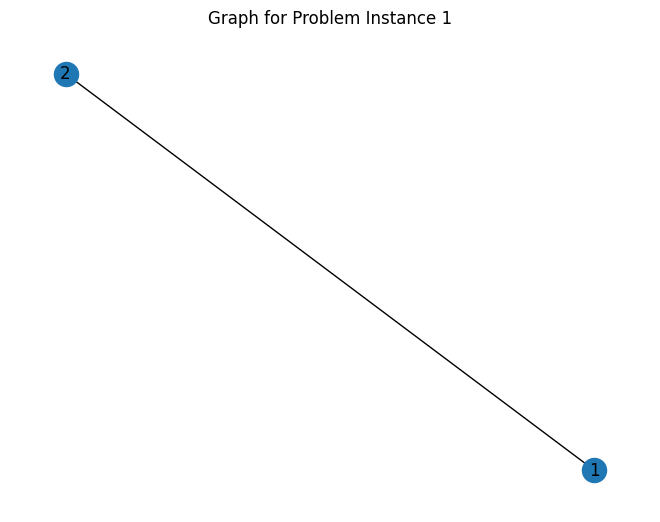

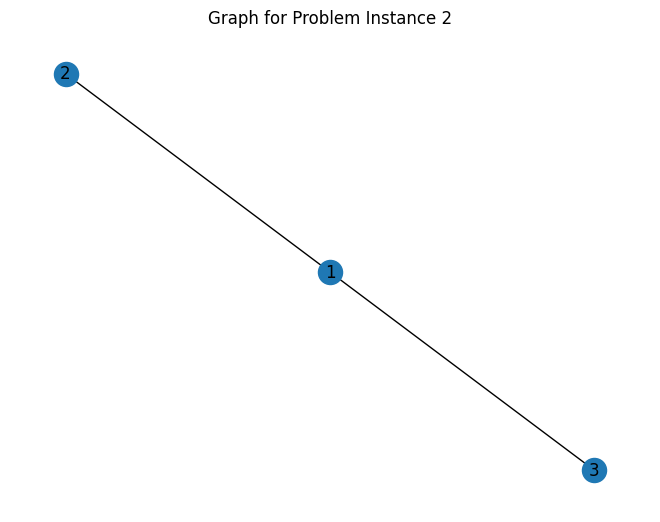

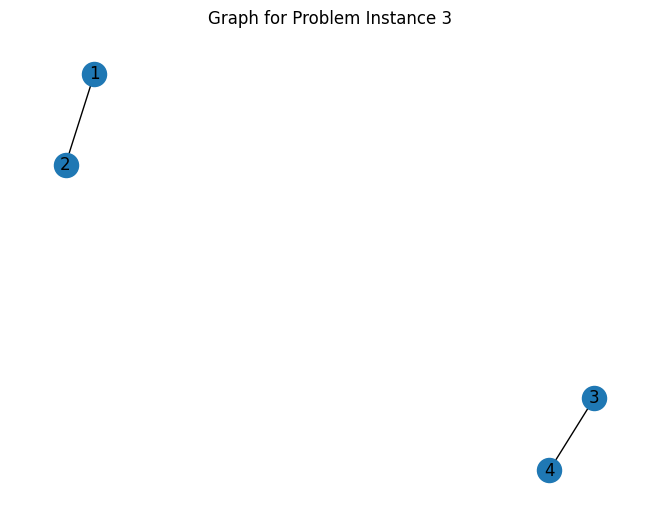

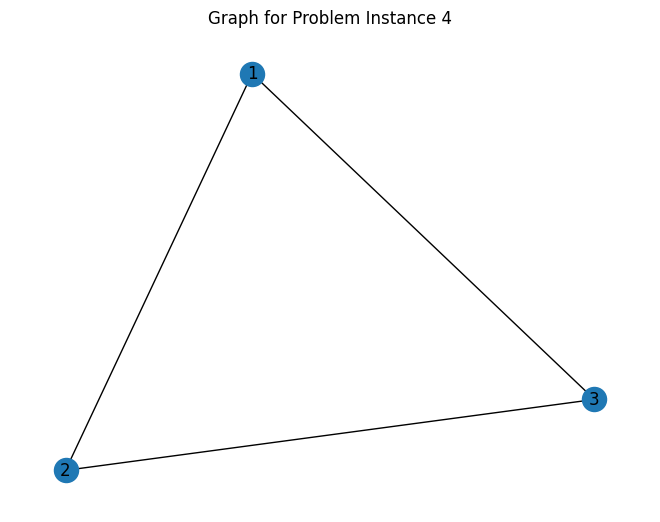

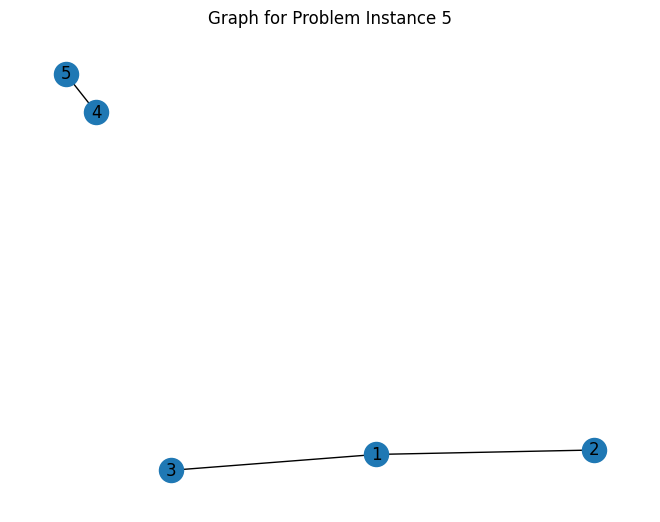

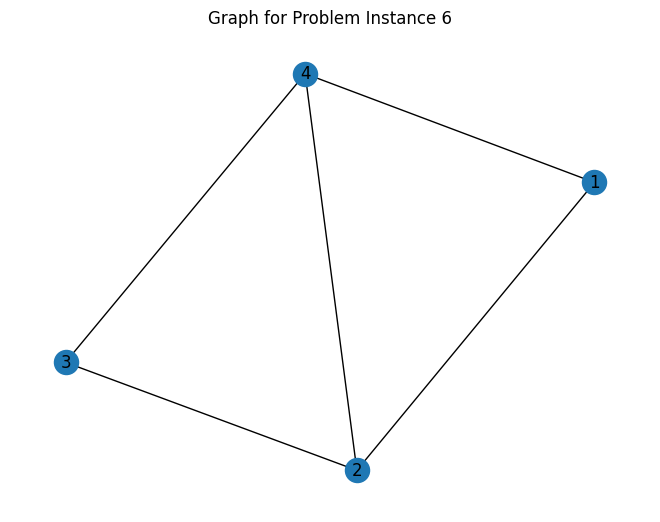

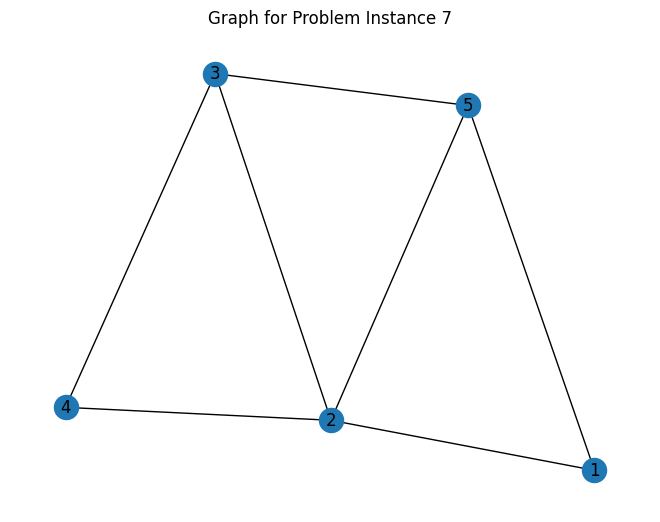

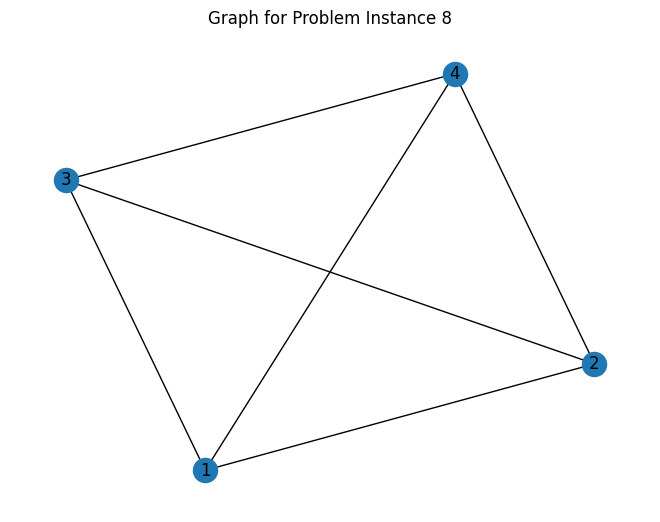

In [10]:
Q_Matrices = []
for problem in range (len(instance_ids)):
    nodes = num_exams_per_instance[problem]
    edges = conflicts_encoded[problem]
    G = draw_graph(nodes,edges[1])

    num_nodes = G.number_of_nodes()
    num_color = timeslots[problem]
    P = 10
    Q = np.eye(num_nodes * num_color)
    for i in range(1, num_nodes +1):
        l = num_color * i + 1
        for j in range(l-num_color,l):
            for k in range(l-num_color, l):
                if k==j:
                    Q[j-1][k-1] = -P
                else:
                    Q[j-1][k-1] = P

    for i, j in G.edges:
        for k in range(1, num_color+1):
            m = (i-1) * num_color + k
            o = (j-1) * num_color + k
            Q[m-1][o-1] = P/2
            Q[o-1][m-1] = P/2  

    Q_Matrices.append(Q)

plt.show()  # Show all the graphs after the loop


In [11]:
QUBO_list = []

for Q in Q_Matrices:
    mdl = Model(name ="GC")
    x = [mdl.binary_var('x%s' % i) for i in range (len(Q))]
    objective = mdl.sum([x[i]* Q[i,j] * x[j] for i in range(len(Q)) for j in range(len(Q))])
    mdl.minimize(objective)
    qp = from_docplex_mp(mdl)
    QUBO_list.append(qp) 



In [12]:
instance_results = []
qaoa_runtime = []

# QAOA Initialisation
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())
qaoa = MinimumEigenOptimizer(qaoa_mes)

print(len(QUBO_list))
for qp in QUBO_list:

    start_time = time.time()
    qaoa_result = qaoa.solve(qp)
    end_time = time.time()
    elapsed_time = end_time - start_time
    qaoa_runtime.append(elapsed_time)

    instance_results.append(qaoa_result)
    print(qaoa_result.prettyprint())
    print("---R---")
    print(qaoa_result.x)
    print("QAOA Runtime: " + str(elapsed_time))

C:\Users\co624\AppData\Local\Temp\ipykernel_13860\3458173304.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())


8
objective function value: -20.0
variable values: x0=0.0, x1=1.0, x2=1.0, x3=0.0
status: SUCCESS
---R---
[0. 1. 1. 0.]
QAOA Runtime: 0.3589482307434082
objective function value: -30.0
variable values: x0=0.0, x1=1.0, x2=1.0, x3=0.0, x4=1.0, x5=0.0
status: SUCCESS
---R---
[0. 1. 1. 0. 1. 0.]
QAOA Runtime: 0.26218199729919434
objective function value: -40.0
variable values: x0=0.0, x1=1.0, x2=1.0, x3=0.0, x4=0.0, x5=1.0, x6=1.0, x7=0.0
status: SUCCESS
---R---
[0. 1. 1. 0. 0. 1. 1. 0.]
QAOA Runtime: 0.7477366924285889
objective function value: -30.0
variable values: x0=0.0, x1=0.0, x2=1.0, x3=0.0, x4=1.0, x5=0.0, x6=1.0, x7=0.0, x8=0.0
status: SUCCESS
---R---
[0. 0. 1. 0. 1. 0. 1. 0. 0.]
QAOA Runtime: 5.908958673477173
objective function value: -50.0
variable values: x0=0.0, x1=1.0, x2=1.0, x3=0.0, x4=1.0, x5=0.0, x6=0.0, x7=1.0, x8=1.0, x9=0.0
status: SUCCESS
---R---
[0. 1. 1. 0. 1. 0. 0. 1. 1. 0.]
QAOA Runtime: 2.567302703857422
objective function value: -40.0
variable values: x0=0.0, 

In [13]:
def assign_color(result, num_color):
    colors = ["BLUE", "GREEN", "RED", "YELLOW", "ORANGE", "PINK", "BLACK", "BROWN", "WHITE", "PURPLE", "VIOLET"]
    color_map = list()
    for pos, val in enumerate(result.x):
      if int(val) == 1:    
            node = pos//num_color + 1
            color = pos%num_color
            color_map.append(colors[color])
            print("for node %s with bin var %s the assigned color is %s"%(node, pos, colors[color]))
    return color_map
    
all_color_maps = []

for i in range (len(QUBO_list)):
  qaoa_color_map = assign_color(instance_results[i],timeslots[i])
  all_color_maps.append(qaoa_color_map)

for node 1 with bin var 1 the assigned color is GREEN
for node 2 with bin var 2 the assigned color is BLUE
for node 1 with bin var 1 the assigned color is GREEN
for node 2 with bin var 2 the assigned color is BLUE
for node 3 with bin var 4 the assigned color is BLUE
for node 1 with bin var 1 the assigned color is GREEN
for node 2 with bin var 2 the assigned color is BLUE
for node 3 with bin var 5 the assigned color is GREEN
for node 4 with bin var 6 the assigned color is BLUE
for node 1 with bin var 2 the assigned color is RED
for node 2 with bin var 4 the assigned color is GREEN
for node 3 with bin var 6 the assigned color is BLUE
for node 1 with bin var 1 the assigned color is GREEN
for node 2 with bin var 2 the assigned color is BLUE
for node 3 with bin var 4 the assigned color is BLUE
for node 4 with bin var 7 the assigned color is GREEN
for node 5 with bin var 8 the assigned color is BLUE
for node 1 with bin var 1 the assigned color is GREEN
for node 2 with bin var 5 the assigned 

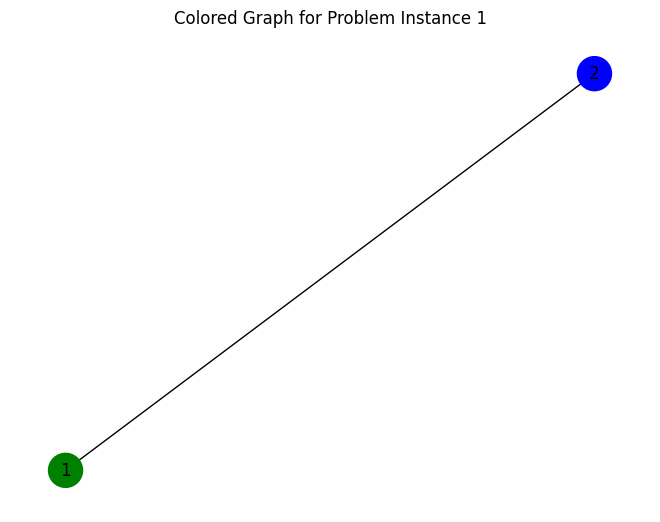

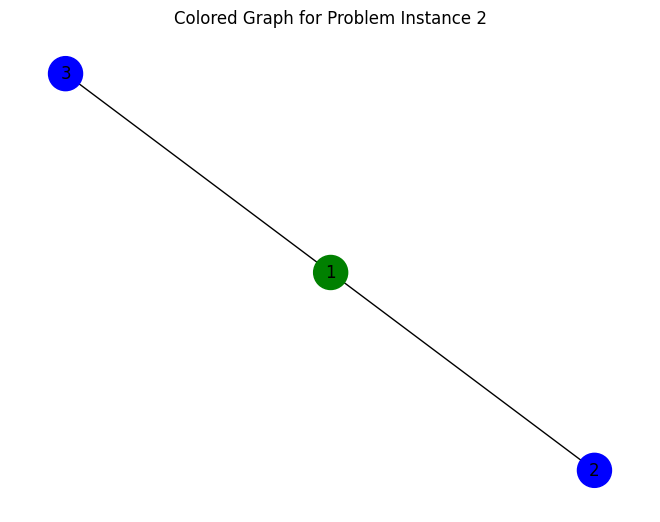

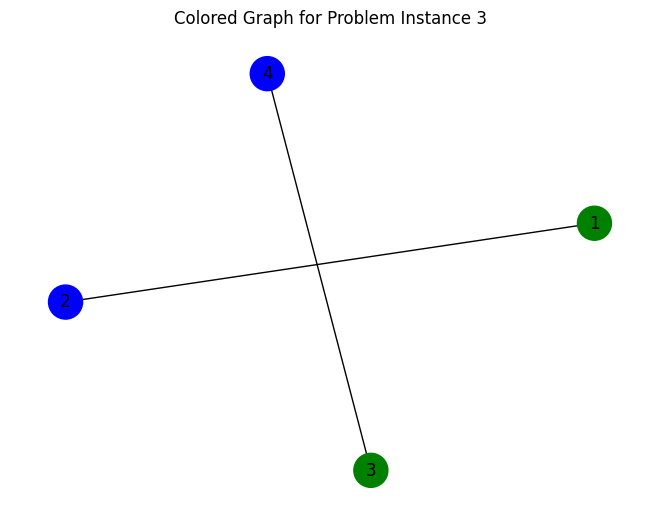

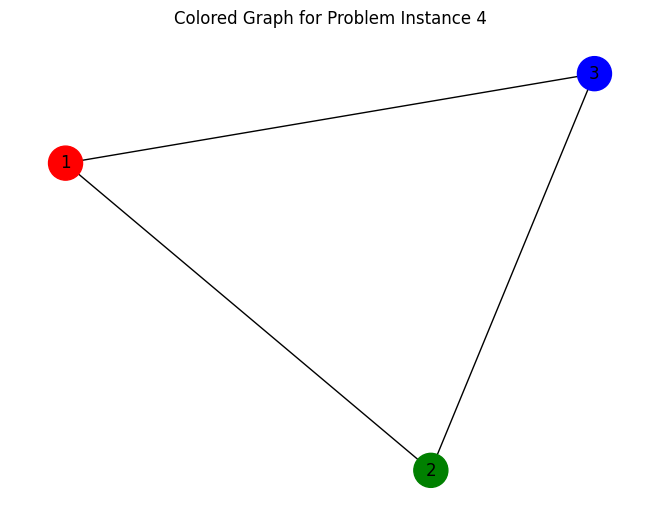

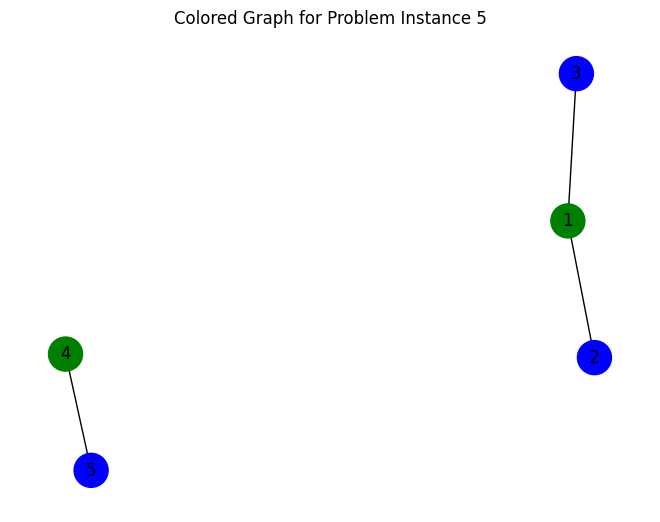

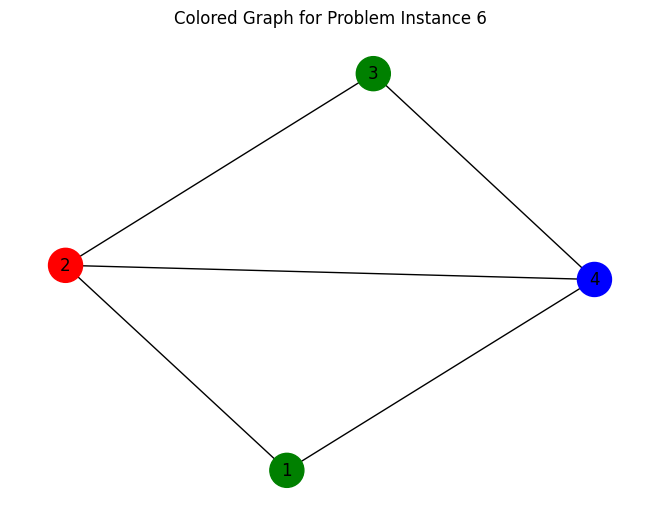

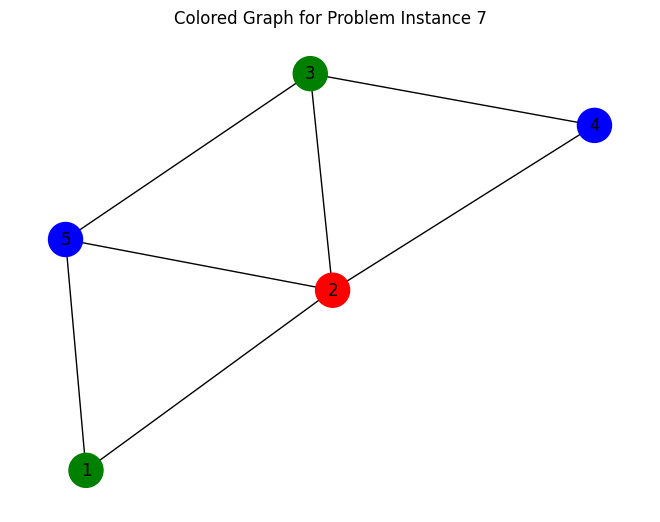

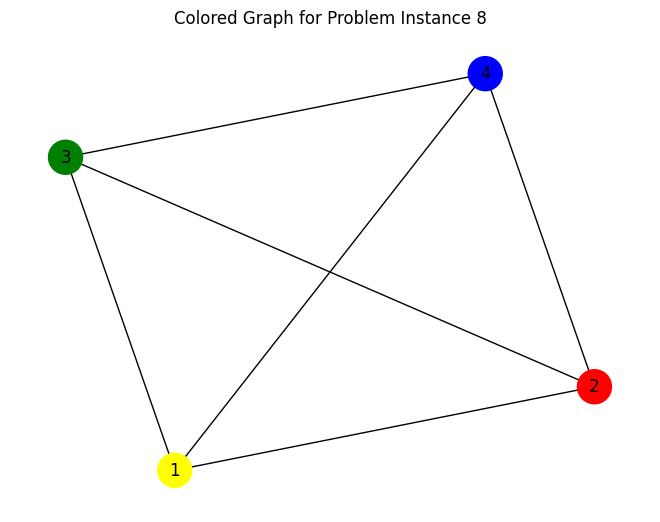

In [18]:
def draw_color_graph(n, e, color_map, instance_id):
    G= nx.Graph()
    G.add_nodes_from([i for i in range(1, n+1)])
    G.add_edges_from(e)

    
    plt.figure()  
    nx.draw(G, node_color=color_map, node_size=600, with_labels= True)
    plt.title(f"Colored Graph for Problem Instance {instance_id}")

    return G

for i in range (len(all_color_maps)):
    n = num_exams_per_instance[i]
    e = conflicts_encoded[i]
    color_map = all_color_maps[i]
    instance_id = instance_ids[i]
    draw_color_graph(n, e[1], color_map, instance_id)
